## 04.7: Working With Point Cloud Data in Python

To conclude our work on working with geospatial data in Python, we would be remiss if we didn't address working with point cloud data. Point clouds are a somewhat distinct, but common form of geospatial data that doesn't conform to either raster or vector data types. Most commonly, point cloud data are derived from lidar platforms – either spaceborne, airborne, or terrestrial scanning. Point cloud data can also be generated from structure from motion (SfM) photogrammetric techniques using drones or other airborne photography. Point cloud data are exactly what they sound like, a collection of points in space (expressed as x-, y-, and z- coordinates) capturing lidar or photogrammetric returns. Points can also be associated with other attributes like RGG colors, intensity of the light return, or – in some cases – the intensity of the return across a broader spectrum (so-called waveform lidar). 

Lidar and other point cloud data are very powerful and can be used to capture geospatial attributes that neither raster nor vector data can capture. For example, lidar data can be used to characterize topographic features over much finer spatial scales of individual landforms like landslides, debris flows, and fault scarps. Lidar can be used in glaciology to measure fine-scale characteristics of glaciers and permanent snow and icefields. Point cloud data are also enormously helpful in ecosystem science because we can use them to characterize structural attributes of terrestrial vegetation and do things like characterize individual trees and shrubs. When we can repeat lidar measurements through time – either due to repeat satellite or aircraft overflights or repeated deployments of terrestrial laser scanners – facilitates analysis of topographic and ecologic change. In fact, the estimate of snow water equivalent from Airborne Snow Observatory (ASO) data that you are using in this unit's problem set is derived from lidar observations. Point cloud data are also used to generate rasters (as in digital surface models and canopy height models), and vector data (as in segmentation of individual trees).

There are many non-Python platforms and tools – some open source and some proprietary – that are used to explore, visualize, manipulate, and analyze point cloud data. And, honestly, Python is probably in last place among them – although there are better packages being developed all the time. As such, Python will not likely replace many of the other tools and platforms you might use to process point cloud/lidar data. However, it can be a helpful complement to other tools to do some basics and it is also worth keeping track of developments in the Python point cloud/lidar data processing space. 

In this notebook, we show a basic workflow to create a digital elevation model (DEM) and canopy height model (CHM) from airborne lidar data covering a 1 km${}^2$ area in Dry Creek watershed that includes the Lower Deer Point site. The only new libraries we're using here is `laspy`, a library to read in LAS or LAZ (compressed LAS) files, and `pyvista`, a library to visualize point cloud (and other surface) datasets.    

### 1. Imports and Definitions

In [1]:
import numpy as np # For handling lidar point cloud data arrays and created rasters
import pyvista as pv # For visualization of point clouds
import matplotlib.pyplot as plt # For plotting derived grids
import laspy # For reading in LAS/LAZ files

# Name of the lidar file we'll be using... more on how we got this in a subsequent class
dcew_laz_fname = '../data/ubrb_lidar/USGS_LPC_ID_FEMAHQ_2018_D18_w1603n2475.laz'

### 2. Read in the Lidar Data and Create a Numpy and PyVista Point Cloud

In [2]:
las = laspy.read(dcew_laz_fname) # Open the LAS file

In [3]:
points = np.vstack((las.x, las.y, las.z)).transpose() # Construct the point cloud

In [4]:
point_cloud = pv.PolyData(points) # Create a PyVista point cloud 

### 3. Create an Interactive Visualization

In [5]:
# Assign Z values as scalar data for coloring
# The Z coordinate is at index 2 (0=X, 1=Y, 2=Z)
point_cloud['elevation'] = point_cloud.points[:, 2]

# 4. Plot the point cloud, coloring by the 'elevation' scalars
# The 'cmap' argument can be used to choose a specific color map (e.g., 'jet', 'viridis', 'terrain')
# render_points_as_spheres=True makes the points look like small spheres, which can improve visualization quality
point_cloud.plot(
    scalars='elevation',
    cmap='jet',  # Use a colormap suitable for elevation data
    render_points_as_spheres=True,
    point_size=2,    # Adjust point size as needed
    show_scalar_bar=True,
    cpos='xy'        # Set camera position for a top-down view initially
)

Widget(value='<iframe src="http://localhost:60410/index.html?ui=P_0x104a93e60_0&reconnect=auto" class="pyvista…

### 4. Create a Digital Elevation Model

We will now use the point cloud to create a "bare earth" digital elevation model (DEM). We construct this bare earth DEM by creating a grid structure that encompasses the horizontal space of our lidar scan. We then analyze each point in the point cloud, determine which grid point the point falls in, and then compare it with the current elevation of the grid cell. If it is less than the current elevation of the cell, the cell elevation is updated to the value of the current cell. We then plot the bare earth DEM. You will still see artifacts of the vegetation in the DEM, which largely reflects where the vegetation density is such that there aren't enough photons that reach the ground surface.  

In [ ]:
# Define the DEM grid
grid_resolution = 1.0
x_min, x_max = points[:,0].min(), points[:,0].max()
y_min, y_max = points[:,1].min(), points[:,1].max()
z_min, z_max = points[:,2].min(), points[:,2].max()

x_grid = np.arange(x_min, x_max + grid_resolution, grid_resolution)
y_grid = np.arange(y_min, y_max + grid_resolution, grid_resolution)

# Initialize DEM grid with a high value (or NaN)
dem_grid = np.full((y_grid.shape[0], x_grid.shape[0]), z_max)

# Assign points to grid cells and find minimum Z
for i in range(points.shape[0]):
    x, y, z = points[i,:]
    
    # Calculate grid indices
    x_idx = int((x - x_min) / grid_resolution)
    y_idx = int((y - y_min) / grid_resolution)
    
    # Update DEM with the minimum Z in the cell
    if 0 <= x_idx < x_grid.shape[0] and 0 <= y_idx < y_grid.shape[0]:
        dem_grid[y_idx, x_idx] = np.min([dem_grid[y_idx, x_idx], z])

# Replace infinite values (cells with no points) with NaN or a chosen fill value
dem_grid[dem_grid == np.inf] = np.nan 

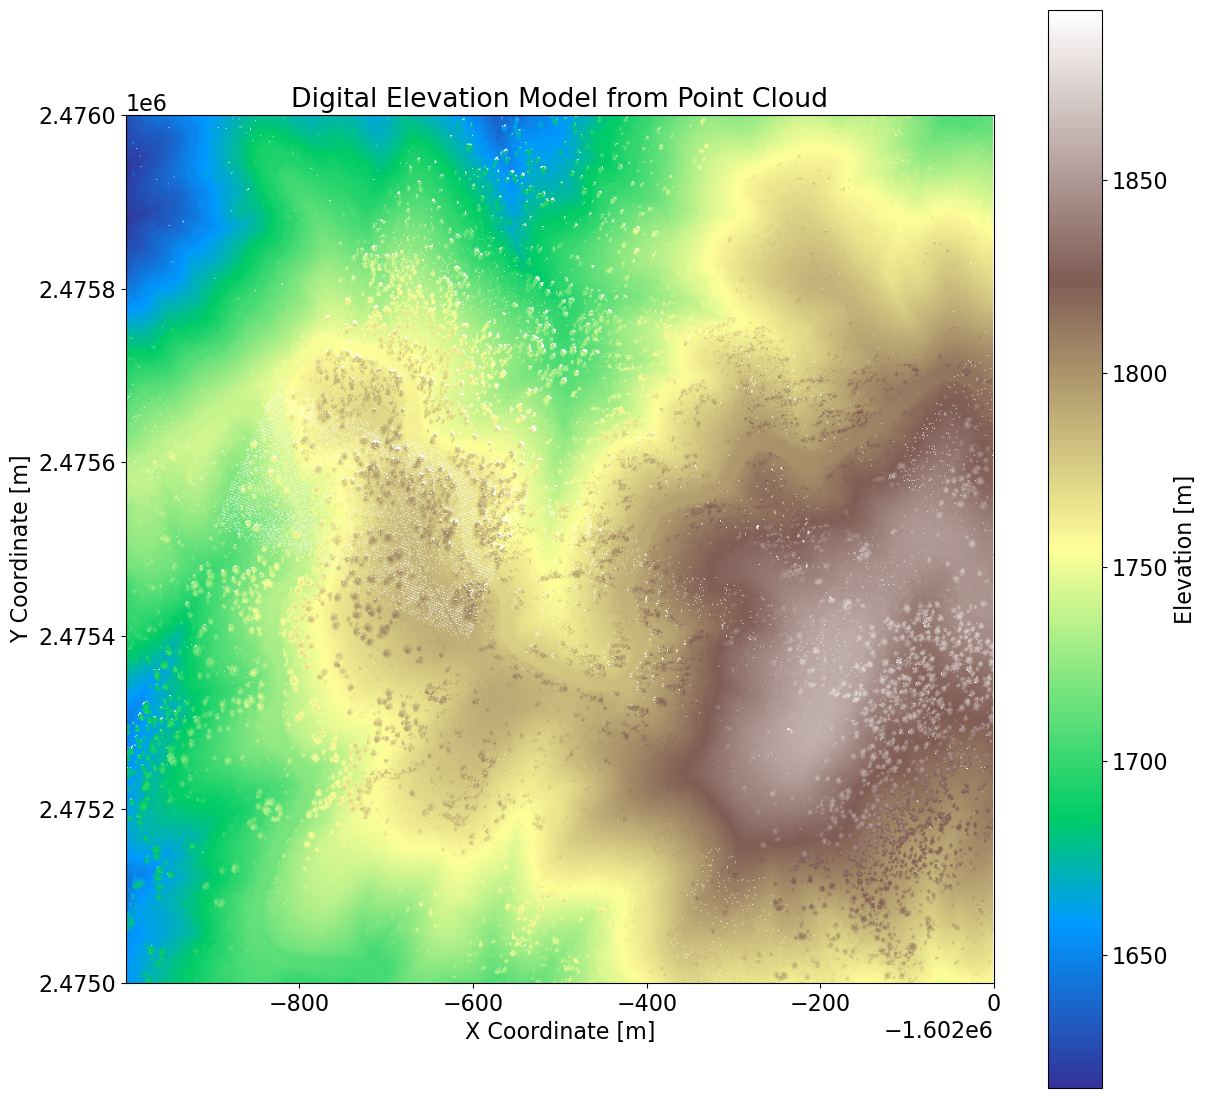

In [7]:
# 4. Visualize the DEM (optional)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,14))
plt.imshow(dem_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='terrain')
plt.colorbar(label='Elevation [m]')
plt.title('Digital Elevation Model from Point Cloud')
plt.xlabel('X Coordinate [m]')
plt.ylabel('Y Coordinate [m]')
plt.show()

### 5. Create a Canopy Height Model

Now let's create a canopy height model (CHM). We can use the same grid we created above, but instead of looking for the minimum elevation of the points falling within each grid cell, we look for the maximum elevation. This grid is then called a "draped surface" grid, because it's like we took a big sheet and draped it over the landscape – trees, bare surfaces, roads, and all. We then subtract the "bare earth" DEM we computed above from that draped surface grid. We also filter for spurious elevations below zero and then we plot the CHM.  

In [8]:
# Initialize draped surface grid with a high value (or NaN)
draped_surf_grid = np.full((y_grid.shape[0], x_grid.shape[0]), z_min)

# Assign points to grid cells and find minimum Z
for i in range(points.shape[0]):
    x, y, z = points[i,:]
    
    # Calculate grid indices
    x_idx = int((x - x_min) / grid_resolution)
    y_idx = int((y - y_min) / grid_resolution)
    
    # Update DEM with the minimum Z in the cell
    if 0 <= x_idx < x_grid.shape[0] and 0 <= y_idx < y_grid.shape[0]:
        draped_surf_grid[y_idx, x_idx] = np.max([draped_surf_grid[y_idx, x_idx], z])

# Replace infinite values (cells with no points) with NaN or a chosen fill value
draped_surf_grid[draped_surf_grid == np.inf] = np.nan 

chm = draped_surf_grid - dem_grid
chm[chm<0.0] = 0.0

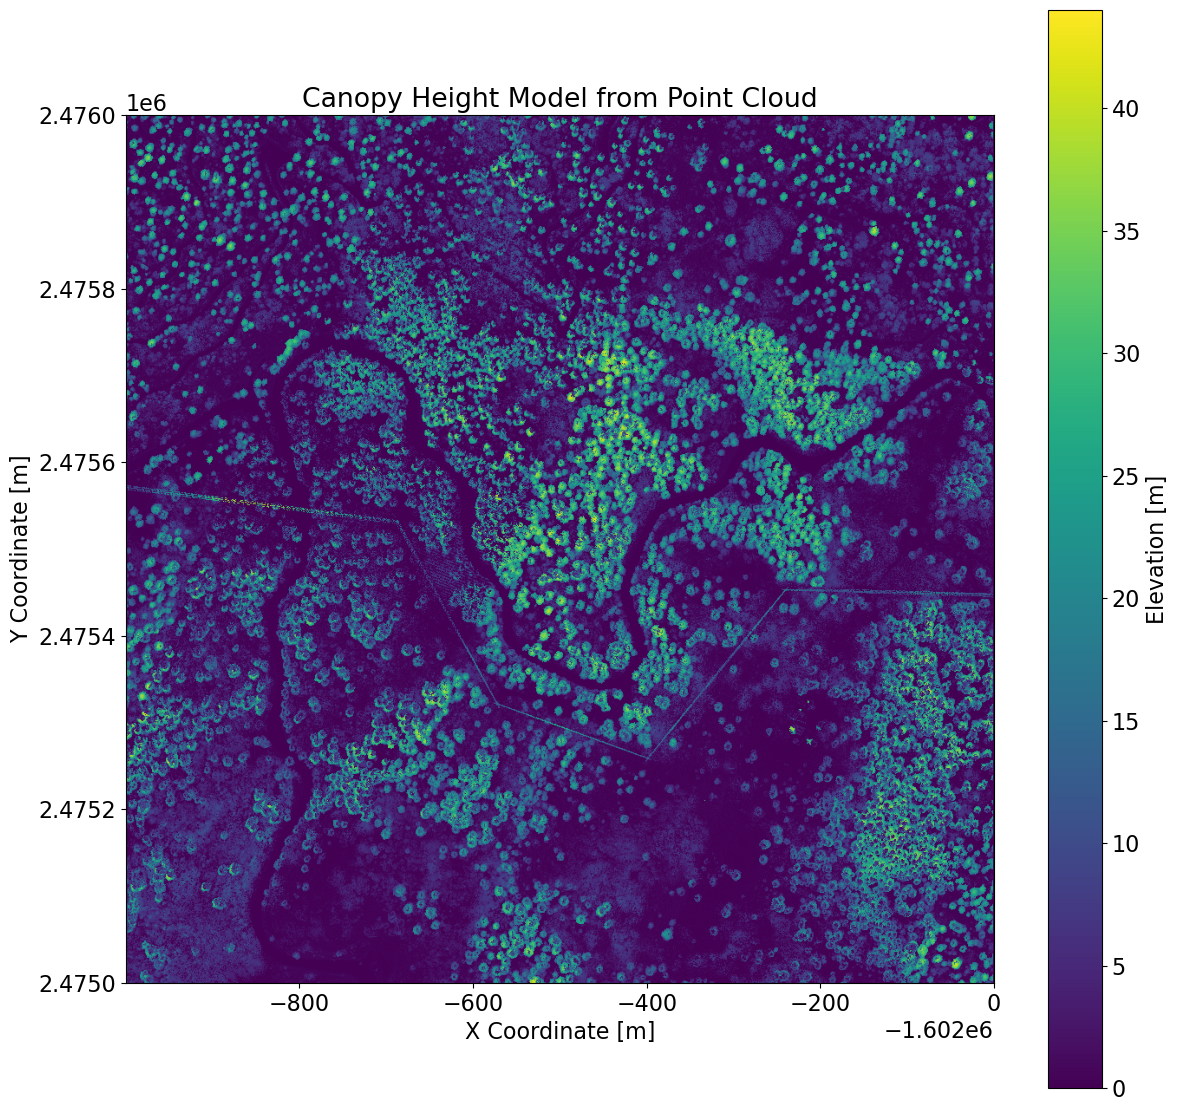

In [9]:
# 4. Visualize the DEM (optional)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(14,14))
plt.imshow(chm, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis')
plt.colorbar(label='Elevation [m]')
plt.title('Canopy Height Model from Point Cloud')
plt.xlabel('X Coordinate [m]')
plt.ylabel('Y Coordinate [m]')
plt.show()